In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from copy import deepcopy

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv('AMZN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


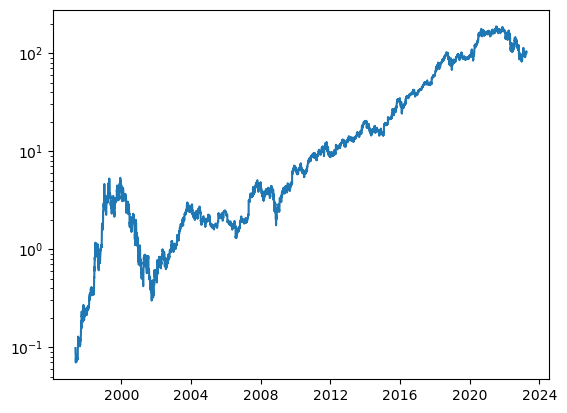

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.yscale('log')

In [19]:
def prep_df_for_lstm(df, n_steps):
    df = df.copy()
    df = df[['Date', 'Close']]
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close-{i}'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

prep_df_for_lstm(df, 8)

,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7,Close-8
Date,,,,,,,,,
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001,97.709999
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
